# 5. Handwritten digit classification using TensorFlow [Phân loại chữ viết tay bằng TensorFlow]
* Hãy xem qua bộ dữ liệu **MNIST**, bao gồm $55,000$ mẫu dữ liệu của các chữ số viết tay (từ 0 đến 9).
* Trong phần này chúng ta sẽ sử dụng ANN để nhận dạng chữ viết tay, từ đây chúng ta có thể hiểu rõ hơn về TensorFlow và TensorBoard.
## 5.1. Importing the required libraries [Import các thư viện cần thiết]

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.pyplot as plt

## 5.2. Loading the dataset
* Trước tiên cần tải tập dữ liệu MNIST vào folder `data/mnist/`.
* `one_hot=True` tức ta sẽ áp dụng one hot encoding cho tập dữ liệu này.

In [2]:
mnist = input_data.read_data_sets("data/mnist", one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
print("Số ảnh có trong training set {}.".format(mnist.train.images.shape))
print("Số label trong tập training set {}.".format(mnist.train.labels.shape))

print("Số ảnh có trong test set {}.".format(mnist.test.images.shape))
print("Số label trong tập test set {}.".format(mnist.test.labels.shape))

Số ảnh có trong training set (55000, 784).
Số label trong tập training set (55000, 10).
Số ảnh có trong test set (10000, 784).
Số label trong tập test set (10000, 10).


* Bây giờ chúng ta sẽ thử visualize một mẫu dữ liệu lên:

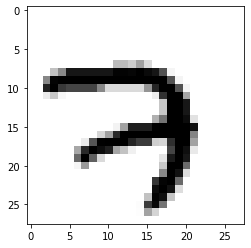

In [4]:
img1 = mnist.train.images[0].reshape(28, 28) # ví có 784 đặt trưng nên kích thước ảnh là 28x28
plt.imshow(img1, cmap='Greys')

## 5.3. Defining the number of neurons in each layer [Xác định số lượng neuron trong từng layer]
* Chúng ta sẽ xây dựng một mạng neuron bao gồm 4 layer với 3 hidden layer và 1 output layer.
* Vì kích thước của từng ảnh là $784$ nên chúng ta đặt `num_input = 784`. Và vì có 10 chữ số (từ 0 đến 9) nên chúng ta sẽ có 10 neuron cho output layer. Cuối cùng chúng ta sẽ xác định số neuron cho từng lớp cụ thể như sau:

In [5]:
# number of neurons in input layer
num_input = 784

# number of neurons in hidden layer 1
num_hidden1 = 512

# number of neurons in hidden layer 2
num_hidden2 = 256

# number of neurons in hidden layer 3
num_hidden3 = 128

# number of neurons in output layer
num_output = 10

## 5.4. Defining placeholders [Xác định các placeholder]
* Bây giờ chúng ta cần xác định các placeholder cho `input` và `output` như sau:

In [6]:
with tf.name_scope('input'):
    X = tf.placeholder('float', [None, num_input])
    
with tf.name_scope('output'):
    Y = tf.placeholder('float', [None, num_output])

* Vì network của chúng ta có 4 layer, vậy nên chúng ta cần tìm 4 `weight` và 4 `bias`. Chúng ta sẽ khởi tạo các `weight` theo phân phối chuẩn với standard deviation bằng $0.1$. Hãy nhớ rằng, số chiều của ma trận trọng số bằng với **số lượng neuron của layer trc** $\times$ **số lượng neuron của layer hiện tại**.
* Chúng ta sẽ định nghĩa tất cả các weight bên trong một dictionary như sau:

In [7]:
with tf.name_scope('weights'):
    weights = {
        'w1': tf.Variable(tf.truncated_normal([num_input, num_hidden1], stddev=0.1), name='weight_1'),
        'w2': tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1), name='weight_2'),
        'w3': tf.Variable(tf.truncated_normal([num_hidden2, num_hidden3], stddev=0.1), name='weight_3'),
        'out': tf.Variable(tf.truncated_normal([num_hidden3, num_output], stddev=0.1), name='weight_4')
    }

* Shape của bias lúc này sẽ bằng số neuron của layer hiện tại. Chúng ta sẽ đặt giá trị bias bằng $0.1$ cho tất cả các layer.

In [8]:
with tf.name_scope('biases'):
    biases = {
        'b1': tf.Variable(tf.constant(0.1, shape=[num_hidden1]), name='bias_1'),
        'b2': tf.Variable(tf.constant(0.1, shape=[num_hidden2]), name='bias_2'),
        'b3': tf.Variable(tf.constant(0.1, shape=[num_hidden3]), name='bias_3'),
        'out': tf.Variable(tf.constant(0.1, shape=[num_output]), name='bias_4')
    }

## 5.5. Forward propagation
* Bây giờm chúng ta sẽ tiến hành forward propagation, chúng ta sẽ sử dụng **ReLU** activation cho tất cả các layer. Ở layer cuối, chúng ta sẽ áp dụng **Sigmoid** activation.

In [9]:
with tf.name_scope('Model'):
    with tf.name_scope('layer1'):
        layer_1 = tf.nn.relu(tf.add(tf.matmul(X, weights['w1']), biases['b1']))
        
    with tf.name_scope('layer2'):
        layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']))
        
    with tf.name_scope('layer3'):
        layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']))
        
    with tf.name_scope('output_layer'):
        y_hat = tf.nn.sigmoid(tf.matmul(layer_3, weights['out']) + biases['out'])

## 5.6. Computing loss and backpropagation
* Bây giờ chúng ta sẽ định nghĩa **loss function**. Chúng ta sẽ sử dụng **softmax cross-entropy** làm hàm mất mát của chúng ta. TensorFlow cung cấp `tf.nn.softmax_cross_entropy_with_logits()` để tính softmax cross-entropy loss. Nó nhận vào hai tham số là `logits` - chỉ định `logits` mà chúng ta sẽ dự đoán trong network, chẳng hạn `y_hat`; `labels` - tham số dùng để chỉ định đâu là **actual labels**, ví dụ `Y`.
* Chúng ta sẽ lấy giá trị mean của hàm mất mát bằng `tf.reduce_mean()`.

In [10]:
with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=Y))

* Bây giờ chúng ta sẽ tiến hành tối thiểu hóa hàm mất mát bằng cách sử dụng backpropagation. Chúng ta sẽ ko cần phải tính đạo hàm như những gì mà chúng ta đã làm ở chapter 1. Thay vào đó chúng ta sẽ sử dụng trình tối ưu dc xây dựng sẵn bởi TensorFlow.
* Trong bài toán này chúng ta sẽ sử dụng Adam optimizer, đây là một biến thể của Gradient Descent mà chúng ta đã tìm hiểu ở chương 1. Chúng ta sẽ tìm hiểu nó kĩ hơn vào chương 3.
* Bây giờ chúng ta sẽ áp dụng Adam optimizer làm thuật toán chính trong backpropagation của chúng ta.

In [11]:
learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

## 5.7. Computing accuracy
* Chúng ta có thể tính toán độ chính xác của model theo các bước sau:
  * Tham số `y_hat` biểu thị xác suất dự đoán cho từng class trong model của chúng ta. Bởi vì chùng ta có 10 class nên chúng ta có 10 giá trị xác suất. Nếu xác suất cao hơn ở số 7, thì khả năng cao model của chúng ta dữ đoán hình ảnh đầu vào là số 7. Hàm `tf.argmax(y_hat, 1)` trả về index của giá trị lớn nhất.
  * `Y` lúc này là actual label, và vì chúng ta áp dụng one hot nên lúc này nó là một mảng chiều phần từ với các phần tử đều là 0 riêng duy nhất actual label là 1.
  * Hàm `tf.equal(<x>, <y>)` nhận vào hai đối số là `x` và `y` và trả về giá trị boolean liệu `x == y` hay ko. Vậy nên trong mã dưới đây của chúng ta như sau:
    ```python
    correct_pred = tf.equal(predicted_digit, actual_digit)
    ```
    * Nó sẽ trả về `True` nếu như `predicted_digit` và `actual_digit` giống nhau và ngược lại là `False`.
  * Tiếp theo chúng ta cần convert giá trị boolean trong `correct_pred` thành giá trị có dtype là float, lúc này ta dùng hàm:
    ```python
    tf.cast(correct_pred, tf.float32)
    ```
    * Sau khi chuyển đổi nó thành dtype là float, chúng ta sẽ tính trung bình bằng hàm `tf.reduce_mean()`.
  * Tóm lại:
    ```python
    tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    ```
    sẽ cho chúng ta giá trị trung bình của các mẫu dc dự đoán đúng.

In [12]:
with tf.name_scope("Accuracy"):
    predicted_digit = tf.argmax(y_hat, 1)
    actual_digit = tf.argmax(Y, 1)
    correct_pred = tf.equal(predicted_digit, actual_digit)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## 5.8. Creating Summary
* Chúng ta có thể visualize loss function và accuracy của model thay đổi như thế nào qua từng vòng lặp trong TensorBoard. Chúng ta sẽ sử dụng hàm `tf.summary()` để lấy dc tóm tắt của biến. Bởi vì hàm loss và accuracy là các **scalar variable** [biến vô hướng], chúng ta sẽ sử dụng `tf.summary.scalar()` như dòng code dưới đây:

In [13]:
tf.summary.scalar("Accuracy", accuracy)
tf.summary.scalar("Loss", loss)

<tf.Tensor 'Loss_1:0' shape=() dtype=string>

* Tiếp theo, chúng ta sẽ gộp nhất tất các các summary mà chúng ta đã sử dụng `tf.summary.merge_all()`. Chúng ta làm điều này bởi vì chúng ta có nhiều giá tri summary vậy nên chúng ta cần gộp nó lại để chạy trong một lần duy nhất chứ ko phải nhiều lần trong một session.

In [14]:
merge_summary = tf.summary.merge_all()

## 5.10. Training the model
* Bây giờ chúng ta sẽ train model của chúng ta. Trc tiên chúng ta cần khởi tạo tao ra biến `global_variables_initializer()`.

In [16]:
init = tf.global_variables_initializer()

* Bây giờ chúng ta cần xác định batch size (số quan sát của training data), số lượng iterations và learning rate, theo dõi dưới đây:

In [ ]:
learning_rate = 1e-4
num_iterations = 1000
batch_size = 128